In [1]:
# import importlib
# import subprocess

# def import_or_install(package):
#             try:
#                 importlib.import_module(package)
#                 print(f'{package} is already installed')
#             except ImportError:
#                 print(f'{package} is not installed, installing now...')
#                 subprocess.check_call(['pip', 'install', package])
#                 print(f'{package} has been installed')

# import_or_install('pandas')
# import_or_install('scikit-learn')
# import_or_install('numpy')
# import_or_install('tensorflow')
# import_or_install('keras')

import pandas as pd
import pandas_market_calendars as mcal
from dateutil import parser
pd.set_option('display.max_columns', None)
from datetime import date, datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np

In [2]:
try:
    data = pd.read_csv('../data/AAPL_cleaned_data.csv')
except:
    data = pd.read_csv('~/Documents/GitHub/Finance-LLM/data/cleaned_data.csv')
data_original = data.copy()
data.head(3)

,date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct
0,2018-05-11,45.120,104848800.0,4.0,0.297,0.206,0.091,60.598,55.270,55.270,46.462,46.462,72.887,72.887,20.424,95.332,95.332,43.543,43.543,43.543,43.543,12.65,119.23,101.41,83.16,148755.0,1.7,3.8,203.2,250.792,7.324,0.6825,0.6725,1.487
1,2018-05-14,45.015,83115200.0,0.0,0.302,0.227,0.074,37.773,49.438,49.438,47.454,47.454,53.406,53.406,12.318,92.491,92.491,43.691,43.691,43.691,43.691,12.93,118.60,101.19,83.16,148755.0,1.7,3.8,203.2,250.792,6.750,0.6825,0.6725,1.487
2,2018-05-15,44.606,94780800.0,1.0,0.279,0.239,0.040,25.000,41.292,41.292,45.400,45.400,33.076,33.076,4.629,82.234,82.234,43.774,43.774,43.774,43.774,14.63,117.25,100.63,83.11,148755.0,1.7,3.8,203.2,250.792,7.333,0.6825,0.6725,1.487


In [3]:
data_original.tail()

,date,close,volume,day,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct
1248,2023-04-27,168.41,64902300.0,3.0,2.367,2.683,-0.316,97.396,62.910,62.910,61.696,61.696,65.339,65.339,1.784,64.084,64.084,157.616,157.616,150.487,150.487,17.03,104.77,98.99,82.09,155673.0,4.83,3.4,257.381,302.918,7.833,1.88,1.94,-3.0928
1249,2023-04-28,169.68,55209200.0,4.0,2.560,2.658,-0.098,97.588,74.470,74.470,65.954,65.954,91.501,91.501,1.953,66.138,66.138,157.903,157.903,150.612,150.612,15.78,106.46,99.73,82.18,155673.0,4.83,3.4,257.381,302.918,7.583,1.88,1.94,-3.0928
1250,2023-05-01,169.59,52472900.0,0.0,2.675,2.662,0.013,88.758,79.233,79.233,70.380,70.380,96.937,96.937,1.928,65.851,65.851,158.221,158.221,150.721,150.721,16.08,103.13,98.32,81.81,155673.0,4.83,3.4,257.381,302.918,7.200,1.88,1.94,-3.0928
1251,2023-05-02,168.54,48425700.0,1.0,2.650,2.659,-0.009,75.033,77.833,77.833,72.864,72.864,87.769,87.769,1.663,62.442,62.442,158.540,158.540,150.816,150.816,17.78,105.70,99.60,82.08,155673.0,4.83,3.4,257.381,302.918,5.429,1.88,1.94,-3.0928
1252,2023-05-03,167.45,65136000.0,2.0,2.514,2.630,-0.116,57.266,70.977,70.977,72.235,72.235,68.461,68.461,1.441,59.026,59.026,158.920,158.920,150.921,150.921,18.34,106.29,100.25,82.28,155673.0,4.83,3.4,257.381,302.918,3.500,1.88,1.94,-3.0928


In [4]:
data.columns

Index(['date', 'close', 'volume', 'day', 'macd', 'macds', 'macdh', 'rsv_9',
       'kdjk_9', 'kdjk', 'kdjd_9', 'kdjd', 'kdjj_9', 'kdjj', 'rs_14', 'rsi_14',
       'rsi', 'close_50_sma', 'ma50', 'close_200_sma', 'ma200', 'vix', 'TLT',
       'IEF', 'SHY', 'NFP', 'InterestRate', 'UnemploymentRate', 'PPI', 'CPI',
       'benz_rate', 'reportedEPS', 'estimatedEPS', 'surprisePct'],
      dtype='object')

In [5]:
# Preprocess encoding date using sin and cos functions
data['date'] = pd.to_datetime(data['date'])
data['month_sin'] = np.sin(2*np.pi*data['date'].dt.month/12)
data['month_cos'] = np.cos(2*np.pi*data['date'].dt.month/12)
data['day_of_month_sin'] = np.sin(2*np.pi*data['date'].dt.day/31)
data['day_of_month_cos'] = np.cos(2*np.pi*data['date'].dt.day/31)
data['day_of_week_sin'] = np.sin(2*np.pi*data['day']/5)
data['day_of_week_cos'] = np.cos(2*np.pi*data['day']/5)
data = data.drop('day', axis=1)
data.head()

,date,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos
0,2018-05-11,45.120,104848800.0,0.297,0.206,0.091,60.598,55.270,55.270,46.462,46.462,72.887,72.887,20.424,95.332,95.332,43.543,43.543,43.543,43.543,12.65,119.23,101.41,83.16,148755.0,1.7,3.8,203.2,250.792,7.324,0.6825,0.6725,1.487,0.5,-0.866025,0.790776,-0.612106,-0.951057,0.309017
1,2018-05-14,45.015,83115200.0,0.302,0.227,0.074,37.773,49.438,49.438,47.454,47.454,53.406,53.406,12.318,92.491,92.491,43.691,43.691,43.691,43.691,12.93,118.60,101.19,83.16,148755.0,1.7,3.8,203.2,250.792,6.750,0.6825,0.6725,1.487,0.5,-0.866025,0.299363,-0.954139,0.000000,1.000000
2,2018-05-15,44.606,94780800.0,0.279,0.239,0.040,25.000,41.292,41.292,45.400,45.400,33.076,33.076,4.629,82.234,82.234,43.774,43.774,43.774,43.774,14.63,117.25,100.63,83.11,148755.0,1.7,3.8,203.2,250.792,7.333,0.6825,0.6725,1.487,0.5,-0.866025,0.101168,-0.994869,0.951057,0.309017
3,2018-05-16,45.022,76732400.0,0.282,0.248,0.034,15.719,32.768,32.768,41.189,41.189,15.925,15.925,5.313,84.159,84.159,43.878,43.878,43.878,43.878,13.42,116.80,100.42,83.11,148755.0,1.7,3.8,203.2,250.792,6.333,0.6825,0.6725,1.487,0.5,-0.866025,-0.101168,-0.994869,0.587785,-0.809017
4,2018-05-17,44.737,69176000.0,0.264,0.251,0.013,-70.464,-1.643,-1.643,26.912,26.912,-58.752,-58.752,3.533,77.939,77.939,43.944,43.944,43.944,43.944,13.43,116.21,100.36,83.13,148755.0,1.7,3.8,203.2,250.792,7.000,0.6825,0.6725,1.487,0.5,-0.866025,-0.299363,-0.954139,-0.587785,-0.809017


In [6]:
# set the 'date' column as the DataFrame's index
data.set_index('date', inplace=True)

# lag the 'close_price' column by 180 trading days
data['close_price_lagged'] = data['close'].shift(-6*30)

# reset the index back to a column
data.reset_index(inplace=True)

# create new data as last 180 trading days of data
new_data = data[data['close_price_lagged'].isna()==True].copy().drop(['close_price_lagged'], axis=1)
data_orig_final = data.copy()
data = data[data['close_price_lagged'].isna()==False].copy()

data = data.drop('date', axis=1)
new_data_original = new_data.copy()
new_data = new_data.drop('date', axis=1)
data.head()

,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,close_price_lagged
0,45.120,104848800.0,0.297,0.206,0.091,60.598,55.270,55.270,46.462,46.462,72.887,72.887,20.424,95.332,95.332,43.543,43.543,43.543,43.543,12.65,119.23,101.41,83.16,148755.0,1.7,3.8,203.2,250.792,7.324,0.6825,0.6725,1.487,0.5,-0.866025,0.790776,-0.612106,-0.951057,0.309017,39.813
1,45.015,83115200.0,0.302,0.227,0.074,37.773,49.438,49.438,47.454,47.454,53.406,53.406,12.318,92.491,92.491,43.691,43.691,43.691,43.691,12.93,118.60,101.19,83.16,148755.0,1.7,3.8,203.2,250.792,6.750,0.6825,0.6725,1.487,0.5,-0.866025,0.299363,-0.954139,0.000000,1.000000,40.100
2,44.606,94780800.0,0.279,0.239,0.040,25.000,41.292,41.292,45.400,45.400,33.076,33.076,4.629,82.234,82.234,43.774,43.774,43.774,43.774,14.63,117.25,100.63,83.11,148755.0,1.7,3.8,203.2,250.792,7.333,0.6825,0.6725,1.487,0.5,-0.866025,0.101168,-0.994869,0.951057,0.309017,40.119
3,45.022,76732400.0,0.282,0.248,0.034,15.719,32.768,32.768,41.189,41.189,15.925,15.925,5.313,84.159,84.159,43.878,43.878,43.878,43.878,13.42,116.80,100.42,83.11,148755.0,1.7,3.8,203.2,250.792,6.333,0.6825,0.6725,1.487,0.5,-0.866025,-0.101168,-0.994869,0.587785,-0.809017,41.259
4,44.737,69176000.0,0.264,0.251,0.013,-70.464,-1.643,-1.643,26.912,26.912,-58.752,-58.752,3.533,77.939,77.939,43.944,43.944,43.944,43.944,13.43,116.21,100.36,83.13,148755.0,1.7,3.8,203.2,250.792,7.000,0.6825,0.6725,1.487,0.5,-0.866025,-0.299363,-0.954139,-0.587785,-0.809017,41.965


In [7]:
# Preprocess date column
# data['Date'] = pd.to_datetime(data['date'])
# data.drop(['date'], axis=1, inplace=True)

# data['Year'] = data['Date'].dt.year
# data['Month'] = data['Date'].dt.month
# data['Day'] = data['Date'].dt.day

# data = pd.get_dummies(data, columns=['Month'])  # one-hot encode month column

In [8]:
# scale data
scaler = StandardScaler()
data.iloc[:, 1:data.shape[1]-1] = scaler.fit_transform(data.iloc[:, 1:data.shape[1]-1])  # standardize year and day columns
new_data.iloc[:, 1:new_data.shape[1]-1] = scaler.fit_transform(new_data.iloc[:, 1:new_data.shape[1]-1])

X = data.drop('close_price_lagged', axis=1).values
y = data['close_price_lagged'].values.reshape(-1, 1)
new_data_X = new_data.values

# reshape for LSTM
X = X.reshape(X.shape[0], 1, X.shape[1])  # reshape to 3D array
new_data_X = new_data_X.reshape(new_data_X.shape[0], 1, new_data_X.shape[1])

In [9]:
data

,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,close_price_lagged
0,45.120,-0.222082,-0.191622,-0.240939,0.106029,0.772491,0.752750,0.752750,0.540795,0.540795,0.941922,0.941922,16.586651,2.945234,2.945234,-1.136712,-1.136712,-1.035497,-1.035497,-0.982911,-1.175141,-1.446228,-1.295047,0.224010,0.701389,-0.542031,-0.471729,-1.065624,0.691016,-0.790231,-0.658893,-0.885461,0.746915,-1.127601,1.097233,-0.834696,-1.343028,0.459326,39.813
1,45.015,-0.612008,-0.189343,-0.230651,0.080739,0.216932,0.586939,0.586939,0.571023,0.571023,0.524258,0.524258,9.446630,2.728276,2.728276,-1.133394,-1.133394,-1.031932,-1.031932,-0.951071,-1.213428,-1.477647,-1.295047,0.224010,0.701389,-0.542031,-0.471729,-1.065624,0.076509,-0.790231,-0.658893,-0.885461,0.746915,-1.127601,0.408250,-1.323086,-0.006995,1.443376,40.100
2,44.606,-0.402714,-0.199824,-0.224772,0.030159,-0.093962,0.355338,0.355338,0.508435,0.508435,0.088392,0.088392,2.673916,1.944985,1.944985,-1.131532,-1.131532,-1.029932,-1.029932,-0.757755,-1.295473,-1.557622,-1.331803,0.224010,0.701389,-0.542031,-0.471729,-1.065624,0.700651,-0.790231,-0.658893,-0.885461,0.746915,-1.127601,0.130372,-1.381245,1.329038,0.459326,40.119
3,45.022,-0.726523,-0.198457,-0.220363,0.021233,-0.319861,0.112990,0.112990,0.380121,0.380121,-0.279317,-0.279317,3.276405,2.091990,2.091990,-1.129200,-1.129200,-1.027427,-1.027427,-0.895350,-1.322821,-1.587612,-1.331803,0.224010,0.701389,-0.542031,-0.471729,-1.065624,-0.369918,-0.790231,-0.658893,-0.885461,0.746915,-1.127601,-0.153314,-1.381245,0.818719,-1.132901,41.259
4,44.737,-0.862094,-0.206659,-0.218893,-0.010007,-2.417550,-0.865359,-0.865359,-0.054917,-0.054917,-1.880357,-1.880357,1.708524,1.616990,1.616990,-1.127720,-1.127720,-1.025837,-1.025837,-0.894213,-1.358677,-1.596181,-1.317101,0.224010,0.701389,-0.542031,-0.471729,-1.065624,0.344151,-0.790231,-0.658893,-0.885461,0.746915,-1.127601,-0.431192,-1.323086,-0.832709,-1.132901,41.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,164.396,-0.970468,2.147881,1.975348,1.013492,1.111376,1.445081,1.445081,1.608354,1.608354,1.005855,1.005855,0.521163,0.904109,0.904109,1.180177,1.180177,1.735839,1.735839,0.054173,-1.256578,-1.093481,-1.802286,1.147788,1.350983,-0.582535,2.179289,2.424570,-0.592596,0.373210,0.606908,-0.709886,-1.212910,-0.615093,1.345818,-0.318575,1.329038,0.459326,168.410
1069,168.702,-0.844252,2.263170,2.068428,1.105726,1.573762,1.576774,1.576774,1.636357,1.636357,1.264415,1.264415,0.989766,1.246918,1.246918,1.189034,1.189034,1.738416,1.738416,-0.176669,-1.303373,-1.084912,-1.743476,1.147788,1.350983,-0.582535,2.179289,2.424570,-0.115123,0.373210,0.606908,-0.709886,-1.212910,-0.615093,1.247293,-0.589508,0.818719,-1.132901,169.680
1070,167.955,-1.077869,2.296436,2.150730,0.965888,1.081146,1.472773,1.472773,1.617861,1.617861,1.055144,1.055144,0.773081,1.101593,1.101593,1.197914,1.197914,1.740897,1.740897,-0.124360,-1.469285,-1.183453,-1.765530,1.147788,1.350983,-0.582535,2.179289,2.424570,-0.547632,0.373210,0.606908,-0.709886,-1.212910,-0.615093,1.097233,-0.834696,-0.832709,-1.132901,169.590
1071,171.553,-0.882486,2.423573,2.243810,1.099776,1.611781,1.610067,1.610067,1.654578,1.654578,1.314026,1.314026,1.186191,1.363224,1.363224,1.208453,1.208453,1.743740,1.743740,-0.200549,-1.398788,-1.124900,-1.750827,1.147788,1.350983,-0.582535,2.179289,2.424570,0.538995,0.373210,0.606908,-0.709886,-1.212910,-0.615093,0.901783,-1.044101,-1.343028,0.459326,168.540


In [10]:
print(data.shape, new_data.shape)

(1073, 39) (180, 38)


In [11]:
data_orig_final.tail()

,date,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,close_price_lagged
1248,2023-04-27,168.41,64902300.0,2.367,2.683,-0.316,97.396,62.910,62.910,61.696,61.696,65.339,65.339,1.784,64.084,64.084,157.616,157.616,150.487,150.487,17.03,104.77,98.99,82.09,155673.0,4.83,3.4,257.381,302.918,7.833,1.88,1.94,-3.0928,0.866025,-0.500000,-0.724793,0.688967,-0.587785,-0.809017,NaN
1249,2023-04-28,169.68,55209200.0,2.560,2.658,-0.098,97.588,74.470,74.470,65.954,65.954,91.501,91.501,1.953,66.138,66.138,157.903,157.903,150.612,150.612,15.78,106.46,99.73,82.18,155673.0,4.83,3.4,257.381,302.918,7.583,1.88,1.94,-3.0928,0.866025,-0.500000,-0.571268,0.820763,-0.951057,0.309017,NaN
1250,2023-05-01,169.59,52472900.0,2.675,2.662,0.013,88.758,79.233,79.233,70.380,70.380,96.937,96.937,1.928,65.851,65.851,158.221,158.221,150.721,150.721,16.08,103.13,98.32,81.81,155673.0,4.83,3.4,257.381,302.918,7.200,1.88,1.94,-3.0928,0.500000,-0.866025,0.201299,0.979530,0.000000,1.000000,NaN
1251,2023-05-02,168.54,48425700.0,2.650,2.659,-0.009,75.033,77.833,77.833,72.864,72.864,87.769,87.769,1.663,62.442,62.442,158.540,158.540,150.816,150.816,17.78,105.70,99.60,82.08,155673.0,4.83,3.4,257.381,302.918,5.429,1.88,1.94,-3.0928,0.500000,-0.866025,0.394356,0.918958,0.951057,0.309017,NaN
1252,2023-05-03,167.45,65136000.0,2.514,2.630,-0.116,57.266,70.977,70.977,72.235,72.235,68.461,68.461,1.441,59.026,59.026,158.920,158.920,150.921,150.921,18.34,106.29,100.25,82.28,155673.0,4.83,3.4,257.381,302.918,3.500,1.88,1.94,-3.0928,0.500000,-0.866025,0.571268,0.820763,0.587785,-0.809017,NaN


In [12]:
from datetime import datetime, timedelta
def conv_to_utc(col):
  date_str = col.strftime('%Y-%m-%d')
  date_obj = datetime.strptime(date_str, '%Y-%m-%d')
  epoch = datetime.utcfromtimestamp(0)
  delta = date_obj - epoch
  days_since_epoch = delta.days
  return days_since_epoch

#appts['Date'] = appts['Date'].apply(conv_to_utc)
#appts['Date']

In [13]:
def conv_from_utc(days_since_epoch):
    epoch = datetime.utcfromtimestamp(0)
    delta = timedelta(days=days_since_epoch)
    date_obj = (epoch + delta).timestamp()
    date_obj = datetime.fromtimestamp(date_obj)
    date_str = date_obj.strftime('%Y-%m-%d')
    return date_str

In [14]:
len(X)

1073

In [15]:
# Split the data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[2])))
for n in range(5):
    model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

# Compile the model with an appropriate learning rate and metric
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=2000, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Use the best model for predictions
y_pred = model.predict(X_test)
x_pred = model.predict(X_train)

# Calculate the MAE
mae = np.mean(np.abs(y_pred - y_test))

# Print the MAE
print("MAE: ", mae)

# Save the model
model.save("best_model.h5")

Epoch 1/2000
27/27 [==============================] - 5s 23ms/step - loss: 74.8921 - mae: 74.8921 - val_loss: 44.5996 - val_mae: 44.5996
Epoch 2/2000
27/27 [==============================] - 0s 3ms/step - loss: 17.8190 - mae: 17.8190 - val_loss: 19.6939 - val_mae: 19.6939
Epoch 3/2000
27/27 [==============================] - 0s 4ms/step - loss: 14.6055 - mae: 14.6055 - val_loss: 24.4793 - val_mae: 24.4793
Epoch 4/2000
27/27 [==============================] - 0s 4ms/step - loss: 11.4141 - mae: 11.4141 - val_loss: 27.6066 - val_mae: 27.6066
Epoch 5/2000
27/27 [==============================] - 0s 4ms/step - loss: 10.4568 - mae: 10.4568 - val_loss: 17.1347 - val_mae: 17.1347
Epoch 6/2000
27/27 [==============================] - 0s 4ms/step - loss: 9.7427 - mae: 9.7427 - val_loss: 15.4293 - val_mae: 15.4293
Epoch 7/2000
27/27 [==============================] - 0s 4ms/step - loss: 8.5957 - mae: 8.5957 - val_loss: 16.6181 - val_mae: 16.6181
Epoch 8/2000
27/27 [==============================]

In [16]:
x_pred = [x[0] for x in x_pred]
y_pred = [x[0] for x in y_pred]
y_pred[:5]

[128.87486, 129.72476, 131.4271, 132.36014, 132.8641]

In [17]:
data_orig_final

,date,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,close_price_lagged
0,2018-05-11,45.120,104848800.0,0.297,0.206,0.091,60.598,55.270,55.270,46.462,46.462,72.887,72.887,20.424,95.332,95.332,43.543,43.543,43.543,43.543,12.65,119.23,101.41,83.16,148755.0,1.70,3.8,203.200,250.792,7.324,0.6825,0.6725,1.4870,0.500000,-0.866025,0.790776,-0.612106,-0.951057,0.309017,39.813
1,2018-05-14,45.015,83115200.0,0.302,0.227,0.074,37.773,49.438,49.438,47.454,47.454,53.406,53.406,12.318,92.491,92.491,43.691,43.691,43.691,43.691,12.93,118.60,101.19,83.16,148755.0,1.70,3.8,203.200,250.792,6.750,0.6825,0.6725,1.4870,0.500000,-0.866025,0.299363,-0.954139,0.000000,1.000000,40.100
2,2018-05-15,44.606,94780800.0,0.279,0.239,0.040,25.000,41.292,41.292,45.400,45.400,33.076,33.076,4.629,82.234,82.234,43.774,43.774,43.774,43.774,14.63,117.25,100.63,83.11,148755.0,1.70,3.8,203.200,250.792,7.333,0.6825,0.6725,1.4870,0.500000,-0.866025,0.101168,-0.994869,0.951057,0.309017,40.119
3,2018-05-16,45.022,76732400.0,0.282,0.248,0.034,15.719,32.768,32.768,41.189,41.189,15.925,15.925,5.313,84.159,84.159,43.878,43.878,43.878,43.878,13.42,116.80,100.42,83.11,148755.0,1.70,3.8,203.200,250.792,6.333,0.6825,0.6725,1.4870,0.500000,-0.866025,-0.101168,-0.994869,0.587785,-0.809017,41.259
4,2018-05-17,44.737,69176000.0,0.264,0.251,0.013,-70.464,-1.643,-1.643,26.912,26.912,-58.752,-58.752,3.533,77.939,77.939,43.944,43.944,43.944,43.944,13.43,116.21,100.36,83.13,148755.0,1.70,3.8,203.200,250.792,7.000,0.6825,0.6725,1.4870,0.500000,-0.866025,-0.299363,-0.954139,-0.587785,-0.809017,41.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2023-04-27,168.410,64902300.0,2.367,2.683,-0.316,97.396,62.910,62.910,61.696,61.696,65.339,65.339,1.784,64.084,64.084,157.616,157.616,150.487,150.487,17.03,104.77,98.99,82.09,155673.0,4.83,3.4,257.381,302.918,7.833,1.8800,1.9400,-3.0928,0.866025,-0.500000,-0.724793,0.688967,-0.587785,-0.809017,NaN
1249,2023-04-28,169.680,55209200.0,2.560,2.658,-0.098,97.588,74.470,74.470,65.954,65.954,91.501,91.501,1.953,66.138,66.138,157.903,157.903,150.612,150.612,15.78,106.46,99.73,82.18,155673.0,4.83,3.4,257.381,302.918,7.583,1.8800,1.9400,-3.0928,0.866025,-0.500000,-0.571268,0.820763,-0.951057,0.309017,NaN
1250,2023-05-01,169.590,52472900.0,2.675,2.662,0.013,88.758,79.233,79.233,70.380,70.380,96.937,96.937,1.928,65.851,65.851,158.221,158.221,150.721,150.721,16.08,103.13,98.32,81.81,155673.0,4.83,3.4,257.381,302.918,7.200,1.8800,1.9400,-3.0928,0.500000,-0.866025,0.201299,0.979530,0.000000,1.000000,NaN
1251,2023-05-02,168.540,48425700.0,2.650,2.659,-0.009,75.033,77.833,77.833,72.864,72.864,87.769,87.769,1.663,62.442,62.442,158.540,158.540,150.816,150.816,17.78,105.70,99.60,82.08,155673.0,4.83,3.4,257.381,302.918,5.429,1.8800,1.9400,-3.0928,0.500000,-0.866025,0.394356,0.918958,0.951057,0.309017,NaN


'cp' is not recognized as an internal or external command,
operable program or batch file.


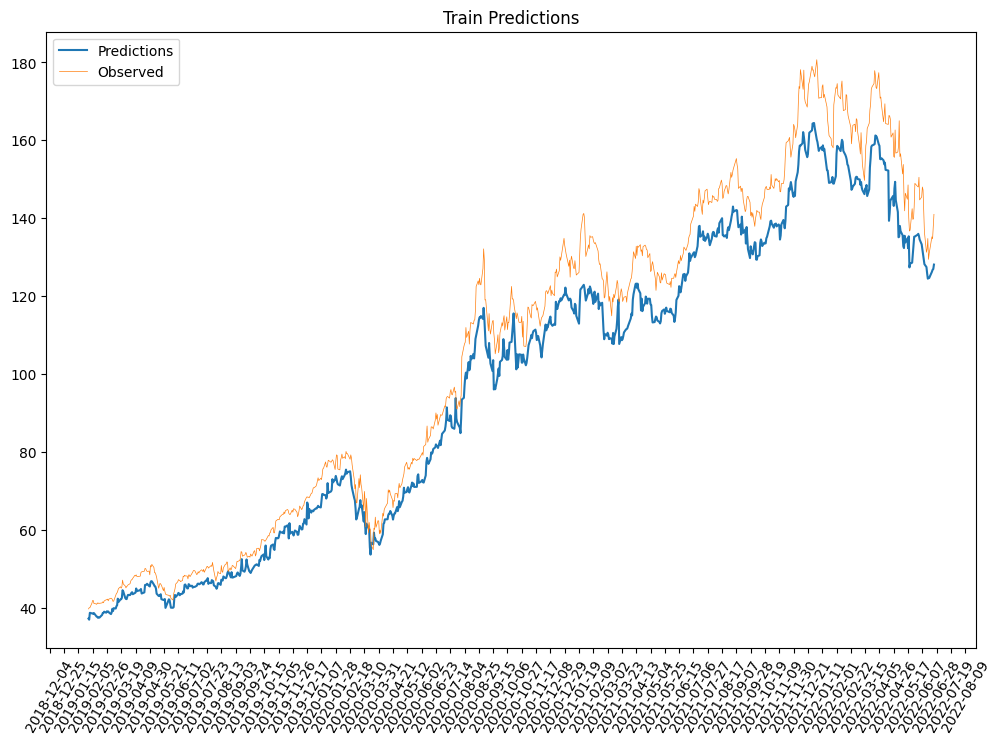

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

preds_train = pd.DataFrame({
    'Date': data_orig_final['date'][180:180+split_idx].reset_index(drop=True),
    'Predictions': x_pred,
    'Observed': data_orig_final['close_price_lagged'][:split_idx]
})

preds_train.to_csv('train_pred.csv')
!cp train_pred.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Train Predictions')
ax.plot('Date', 'Predictions', data=preds_train, label='Predictions')
ax.plot('Date', 'Observed', data=preds_train, label='Observed', linewidth=0.5) # set alpha to 0.5 for the Observed line
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
ax.legend()
plt.show()

In [19]:
data_orig_final.shape

(1253, 40)

In [21]:
data_orig_final['date'][split_idx: data_orig_final.shape[0]-180]

858    2021-10-07
859    2021-10-08
860    2021-10-11
861    2021-10-12
862    2021-10-13
          ...    
1068   2022-08-09
1069   2022-08-10
1070   2022-08-11
1071   2022-08-12
1072   2022-08-15
Name: date, Length: 215, dtype: datetime64[ns]

In [27]:
data_orig_final

,date,close,volume,macd,macds,macdh,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,rs_14,rsi_14,rsi,close_50_sma,ma50,close_200_sma,ma200,vix,TLT,IEF,SHY,NFP,InterestRate,UnemploymentRate,PPI,CPI,benz_rate,reportedEPS,estimatedEPS,surprisePct,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,close_price_lagged
0,2018-05-11,45.120,104848800.0,0.297,0.206,0.091,60.598,55.270,55.270,46.462,46.462,72.887,72.887,20.424,95.332,95.332,43.543,43.543,43.543,43.543,12.65,119.23,101.41,83.16,148755.0,1.70,3.8,203.200,250.792,7.324,0.6825,0.6725,1.4870,0.500000,-0.866025,0.790776,-0.612106,-0.951057,0.309017,39.813
1,2018-05-14,45.015,83115200.0,0.302,0.227,0.074,37.773,49.438,49.438,47.454,47.454,53.406,53.406,12.318,92.491,92.491,43.691,43.691,43.691,43.691,12.93,118.60,101.19,83.16,148755.0,1.70,3.8,203.200,250.792,6.750,0.6825,0.6725,1.4870,0.500000,-0.866025,0.299363,-0.954139,0.000000,1.000000,40.100
2,2018-05-15,44.606,94780800.0,0.279,0.239,0.040,25.000,41.292,41.292,45.400,45.400,33.076,33.076,4.629,82.234,82.234,43.774,43.774,43.774,43.774,14.63,117.25,100.63,83.11,148755.0,1.70,3.8,203.200,250.792,7.333,0.6825,0.6725,1.4870,0.500000,-0.866025,0.101168,-0.994869,0.951057,0.309017,40.119
3,2018-05-16,45.022,76732400.0,0.282,0.248,0.034,15.719,32.768,32.768,41.189,41.189,15.925,15.925,5.313,84.159,84.159,43.878,43.878,43.878,43.878,13.42,116.80,100.42,83.11,148755.0,1.70,3.8,203.200,250.792,6.333,0.6825,0.6725,1.4870,0.500000,-0.866025,-0.101168,-0.994869,0.587785,-0.809017,41.259
4,2018-05-17,44.737,69176000.0,0.264,0.251,0.013,-70.464,-1.643,-1.643,26.912,26.912,-58.752,-58.752,3.533,77.939,77.939,43.944,43.944,43.944,43.944,13.43,116.21,100.36,83.13,148755.0,1.70,3.8,203.200,250.792,7.000,0.6825,0.6725,1.4870,0.500000,-0.866025,-0.299363,-0.954139,-0.587785,-0.809017,41.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2023-04-27,168.410,64902300.0,2.367,2.683,-0.316,97.396,62.910,62.910,61.696,61.696,65.339,65.339,1.784,64.084,64.084,157.616,157.616,150.487,150.487,17.03,104.77,98.99,82.09,155673.0,4.83,3.4,257.381,302.918,7.833,1.8800,1.9400,-3.0928,0.866025,-0.500000,-0.724793,0.688967,-0.587785,-0.809017,NaN
1249,2023-04-28,169.680,55209200.0,2.560,2.658,-0.098,97.588,74.470,74.470,65.954,65.954,91.501,91.501,1.953,66.138,66.138,157.903,157.903,150.612,150.612,15.78,106.46,99.73,82.18,155673.0,4.83,3.4,257.381,302.918,7.583,1.8800,1.9400,-3.0928,0.866025,-0.500000,-0.571268,0.820763,-0.951057,0.309017,NaN
1250,2023-05-01,169.590,52472900.0,2.675,2.662,0.013,88.758,79.233,79.233,70.380,70.380,96.937,96.937,1.928,65.851,65.851,158.221,158.221,150.721,150.721,16.08,103.13,98.32,81.81,155673.0,4.83,3.4,257.381,302.918,7.200,1.8800,1.9400,-3.0928,0.500000,-0.866025,0.201299,0.979530,0.000000,1.000000,NaN
1251,2023-05-02,168.540,48425700.0,2.650,2.659,-0.009,75.033,77.833,77.833,72.864,72.864,87.769,87.769,1.663,62.442,62.442,158.540,158.540,150.816,150.816,17.78,105.70,99.60,82.08,155673.0,4.83,3.4,257.381,302.918,5.429,1.8800,1.9400,-3.0928,0.500000,-0.866025,0.394356,0.918958,0.951057,0.309017,NaN


'cp' is not recognized as an internal or external command,
operable program or batch file.


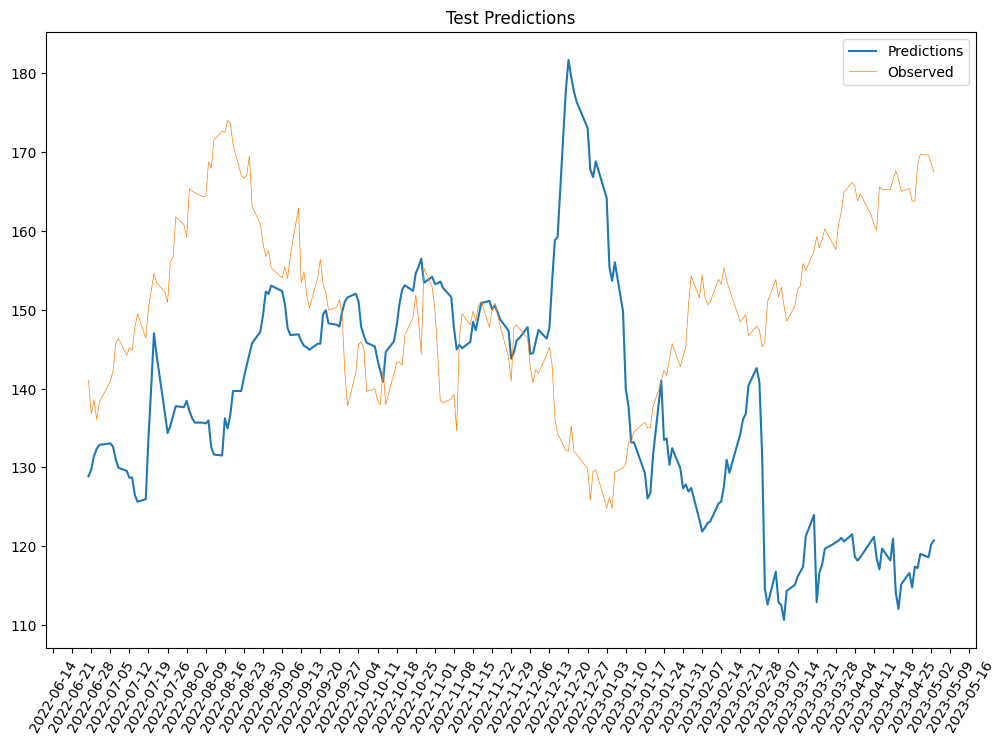

In [22]:
import matplotlib.pyplot as plt
preds_test = pd.DataFrame({
    'Date': data_orig_final['date'][split_idx+180: data_orig_final.shape[0]].reset_index(drop=True),
    'Predictions': y_pred,
    'Observed': data_orig_final['close_price_lagged'][split_idx: data_orig_final.shape[0]-180].reset_index(drop=True)
})

preds_test.to_csv('test_pred.csv')
!cp test_pred.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Test Predictions')
ax.plot('Date', 'Predictions', data=preds_test, label='Predictions')
ax.plot('Date', 'Observed', data=preds_test, label='Observed', linewidth=0.5) # set alpha to 0.5 for the Observed line
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend()
plt.show()

In [ ]:
# Predict next 6 months
# Prepare the data
#Reshape X to match LSTM input shape
new_pred = model.predict(new_data_X)
new_pred = [x[0] for x in new_pred]
new_pred[:5]

In [ ]:
data_orig_final.head()

In [ ]:
new_data_original['Date']

In [ ]:
def get_trading_date(n, start_date_str):
    start_date = parser.parse(start_date_str)
    nyse = mcal.get_calendar('NYSE')
    # Get the next n trading days, excluding today
    next_n_days = nyse.valid_days(start_date=start_date + timedelta(days=1), end_date=start_date + timedelta(days=n*2))
    trading_days = next_n_days[:n]
    trading_days = [day.date().isoformat() for day in trading_days]
    return trading_days

In [ ]:
import matplotlib.pyplot as plt
new_preds = pd.DataFrame({
    'Date': get_trading_date(180, '2023-05-04'),
    'Predictions': new_pred,
})

new_preds.to_csv('new_preds.csv')
!cp new_preds.csv "$path"

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Next 6 Months Predictions')
ax.plot('Date', 'Predictions', data=new_preds, label='Predictions')
plt.xticks(rotation=60)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.legend()
plt.show()

In [ ]:
date_new = pd.concat([appts_model['Date'], new_data['Date']], axis=0)
len_zeros = int(len(date_new)-len(appts_model['StudentName']))
observed_new = pd.concat([appts_model['StudentName'], pd.Series(np.zeros(len_zeros))], axis=0)
predictions_new = pd.concat([preds_train['Predictions'], preds_test['Predictions'], new_preds['Predictions']])

predictions_concat = pd.DataFrame({
    'Date': date_new,
    'Observed': observed_new,
    'Predictions': predictions_new
})

In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Create a trace for the observed values
trace_observed = go.Scatter(x=predictions_concat['Date'], y=predictions_concat['Observed'], name='Observed')

# Create a trace for the predictions
trace_predictions = go.Scatter(x=predictions_concat['Date'], y=predictions_concat['Predictions'], name='Predictions')

# Create a layout for the graph
layout = go.Layout(
    title='Next 6 Months Predictions',
    xaxis=dict(title='Date', tickangle=60),
    yaxis=dict(title='Values'),
)

# Create a figure and add the traces and layout
fig = go.Figure(data=[trace_observed, trace_predictions], layout=layout)

# Show the graph
fig.show()